In [1]:
# Dependencies
import requests
import json
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import math

In [2]:
# Use Pandas to read data
allergy_request = pd.read_csv("data/food-allergy-analysis-Zenodo.csv")
allergy_request.head()

,SUBJECT_ID,BIRTH_YEAR,GENDER_FACTOR,RACE_FACTOR,ETHNICITY_FACTOR,PAYER_FACTOR,ATOPIC_MARCH_COHORT,AGE_START_YEARS,AGE_END_YEARS,SHELLFISH_ALG_START,...,CASHEW_ALG_END,ATOPIC_DERM_START,ATOPIC_DERM_END,ALLERGIC_RHINITIS_START,ALLERGIC_RHINITIS_END,ASTHMA_START,ASTHMA_END,FIRST_ASTHMARX,LAST_ASTHMARX,NUM_ASTHMARX
0,1,2006,S1 - Female,R1 - Black,E0 - Non-Hispanic,P1 - Medicaid,False,0.093087,3.164956,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1994,S1 - Female,R0 - White,E0 - Non-Hispanic,P0 - Non-Medicaid,False,12.232717,18.880219,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.262834,18.880219,2.0
2,3,2006,S0 - Male,R0 - White,E1 - Hispanic,P0 - Non-Medicaid,True,0.010951,6.726899,NaN,...,NaN,4.884326,NaN,3.917864,6.157426,5.127995,NaN,1.404517,6.157426,4.0
3,4,2004,S0 - Male,R4 - Unknown,E1 - Hispanic,P0 - Non-Medicaid,False,2.398357,9.111567,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2006,S1 - Female,R1 - Black,E0 - Non-Hispanic,P0 - Non-Medicaid,False,0.013689,6.193018,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Generate columns list for columns we want
Columns_list = ['SHELLFISH_ALG_START',
       'SHELLFISH_ALG_END', 'FISH_ALG_START', 'FISH_ALG_END', 'MILK_ALG_START',
       'MILK_ALG_END', 'SOY_ALG_START', 'SOY_ALG_END', 'EGG_ALG_START',
       'EGG_ALG_END', 'WHEAT_ALG_START', 'WHEAT_ALG_END', 'PEANUT_ALG_START',
       'PEANUT_ALG_END', 'SESAME_ALG_START', 'SESAME_ALG_END', 'WALNUT_ALG_START',
       'WALNUT_ALG_END', 'PECAN_ALG_START', 'PECAN_ALG_END',
       'PISTACH_ALG_START', 'PISTACH_ALG_END', 'ALMOND_ALG_START',
       'ALMOND_ALG_END', 'BRAZIL_ALG_START', 'BRAZIL_ALG_END',
       'HAZELNUT_ALG_START', 'HAZELNUT_ALG_END', 'CASHEW_ALG_START',
       'CASHEW_ALG_END']

In [4]:
# Remove all unnecessary columns (non-food related allergies)
food_allergy = allergy_request.drop(columns=["FIRST_ASTHMARX","LAST_ASTHMARX","NUM_ASTHMARX","ASTHMA_END","ASTHMA_START","ALLERGIC_RHINITIS_END","ALLERGIC_RHINITIS_START","ATOPIC_DERM_END","ATOPIC_DERM_START","TREENUT_ALG_START","TREENUT_ALG_END"], axis=1)
# Create copy of DataFrame for use
food_allergy_clean = food_allergy.copy()
# Change column values from categories to float
food_allergy_clean[Columns_list] = food_allergy_clean[Columns_list].astype("float")
food_allergy_clean.head()

,SUBJECT_ID,BIRTH_YEAR,GENDER_FACTOR,RACE_FACTOR,ETHNICITY_FACTOR,PAYER_FACTOR,ATOPIC_MARCH_COHORT,AGE_START_YEARS,AGE_END_YEARS,SHELLFISH_ALG_START,...,PISTACH_ALG_START,PISTACH_ALG_END,ALMOND_ALG_START,ALMOND_ALG_END,BRAZIL_ALG_START,BRAZIL_ALG_END,HAZELNUT_ALG_START,HAZELNUT_ALG_END,CASHEW_ALG_START,CASHEW_ALG_END
0,1,2006,S1 - Female,R1 - Black,E0 - Non-Hispanic,P1 - Medicaid,False,0.093087,3.164956,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1994,S1 - Female,R0 - White,E0 - Non-Hispanic,P0 - Non-Medicaid,False,12.232717,18.880219,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2006,S0 - Male,R0 - White,E1 - Hispanic,P0 - Non-Medicaid,True,0.010951,6.726899,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2004,S0 - Male,R4 - Unknown,E1 - Hispanic,P0 - Non-Medicaid,False,2.398357,9.111567,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2006,S1 - Female,R1 - Black,E0 - Non-Hispanic,P0 - Non-Medicaid,False,0.013689,6.193018,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Create dictionary containing allergy keys and respective data values
allergyDict = {}
 
# Key is allergy name, values are severity levels
allergyDict["Shellfish Allergy"] = ["SHELLFISH_ALG_START", "SHELLFISH_ALG_END"]
allergyDict["Fish Allergy"] = ["FISH_ALG_START", "FISH_ALG_END"]
allergyDict["Milk Allergy"] = ["MILK_ALG_START", "MILK_ALG_END"]
allergyDict["Soy Allergy"] = ["SOY_ALG_START", "SOY_ALG_END"]
allergyDict["Egg Allergy"] = ["EGG_ALG_START", "EGG_ALG_END"]
allergyDict["Wheat Allergy"] = ["WHEAT_ALG_START", "WHEAT_ALG_END"]
allergyDict["Peanut Allergy"] = ["PEANUT_ALG_START", "PEANUT_ALG_END"]
allergyDict["Sesame Allergy"] = ["SESAME_ALG_START", "SESAME_ALG_END"]
allergyDict["Walnut Allergy"] = ["WALNUT_ALG_START", "WALNUT_ALG_END"]
allergyDict["Pecan Allergy"] = ["PECAN_ALG_START", "PECAN_ALG_END"]
allergyDict["Pistachio Allergy"] = ["PISTACH_ALG_START", "PISTACH_ALG_END"]
allergyDict["Almond Allergy"] = ["ALMOND_ALG_START", "ALMOND_ALG_END"]
allergyDict["Brazil Nut Allergy"] = ["BRAZIL_ALG_START", "BRAZIL_ALG_END"]
allergyDict["Hazelnut Allergy"] = ["HAZELNUT_ALG_START", "HAZELNUT_ALG_END"]
allergyDict["Cashew Allergy"] = ["CASHEW_ALG_START", "CASHEW_ALG_END"]

In [6]:
# Allergy severity values are levels. We use binning to sort the values by these levels.
bins = [-50, 0.35, 0.69, 3.49, 17.49, 50, 100, 1000]
group_names = ["0", "1", "2", "3", "4", "5", "6"]

for col in Columns_list:
    food_allergy_clean[col] = pd.cut(food_allergy_clean[col], bins, labels=group_names, include_lowest=True)
 
food_allergy_clean.head()

,SUBJECT_ID,BIRTH_YEAR,GENDER_FACTOR,RACE_FACTOR,ETHNICITY_FACTOR,PAYER_FACTOR,ATOPIC_MARCH_COHORT,AGE_START_YEARS,AGE_END_YEARS,SHELLFISH_ALG_START,...,PISTACH_ALG_START,PISTACH_ALG_END,ALMOND_ALG_START,ALMOND_ALG_END,BRAZIL_ALG_START,BRAZIL_ALG_END,HAZELNUT_ALG_START,HAZELNUT_ALG_END,CASHEW_ALG_START,CASHEW_ALG_END
0,1,2006,S1 - Female,R1 - Black,E0 - Non-Hispanic,P1 - Medicaid,False,0.093087,3.164956,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1994,S1 - Female,R0 - White,E0 - Non-Hispanic,P0 - Non-Medicaid,False,12.232717,18.880219,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2006,S0 - Male,R0 - White,E1 - Hispanic,P0 - Non-Medicaid,True,0.010951,6.726899,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2004,S0 - Male,R4 - Unknown,E1 - Hispanic,P0 - Non-Medicaid,False,2.398357,9.111567,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2006,S1 - Female,R1 - Black,E0 - Non-Hispanic,P0 - Non-Medicaid,False,0.013689,6.193018,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


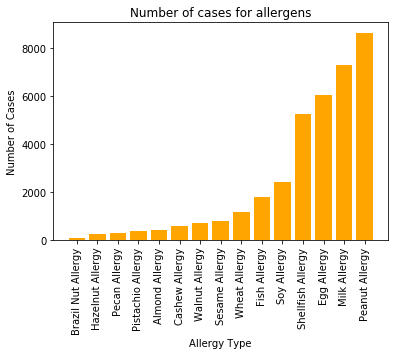

In [7]:
# Make a list to save the count of each allergy and their name.
count = []
allergenTitle = []

# Using the allergy dictionary we created earlier, cycle through and find the first value in values and count.
for keys, values in allergyDict.items():
    count.append(food_allergy_clean[allergyDict[keys][0]].count())
    allergenTitle.append(keys)

totalAllergen_df = pd.DataFrame({
    "Allergy" : allergenTitle,
    "Number of Cases" : count
})

totalAllergen_df.sort_values(by="Number of Cases", ascending=False)

# Number of cases for each allergy type
plt.xlabel("Allergy Type")
plt.ylabel("Number of Cases")
plt.xticks(rotation=90)
plt.title ("Number of cases for allergens")
totalAllergen_df_sorted = totalAllergen_df.sort_values('Number of Cases')
plt.bar('Allergy', 'Number of Cases', data=totalAllergen_df_sorted, color='orange')
plt.show()

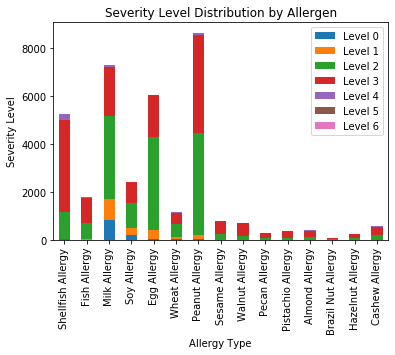

In [8]:
# Create new DataFrame for allergy severity
allergy_name = []
allergy_severity_df = pd.DataFrame()

for keys, values in allergyDict.items():
    allergy_name.append(keys)
    df = pd.DataFrame(food_allergy_clean.groupby(allergyDict[keys][0]).size())
    df1 = df.T
    allergy_severity_df = pd.concat([allergy_severity_df, df1])

allergy_severity_df.index=allergy_name
allergy_severity_df

# Create stacked bar graph to show distribution of severity levels by allergen
allergy_severity_df.plot(kind='bar',stacked=True, title = "Severity Level Distribution by Allergen")
plt.xlabel("Allergy Type")
plt.ylabel("Severity Level")
labels = ["Level 0", "Level 1", "Level 2", "Level 3", "Level 4", "Level 5", "Level 6"]
plt.legend(labels = labels)

In [9]:
# Make new DataFrame to save allergies by birth year
birth_allergy = pd.DataFrame()
# Create list of all years in dataset
birth_years = [2006, 1994, 2004, 2005, 2003, 1999, 1997, 2001, 1990, 1993, 2002,
       2000, 1995, 1998, 1992, 1996, 1987, 1991, 1985, 1989, 1988, 2008,
       2007, 1986, 1984, 2009, 2010, 1983, 2012, 2011]
birth_years.sort()


for x in birth_years:
    year_df = food_allergy_clean[food_allergy_clean["BIRTH_YEAR"]==x]
    allergy_count = []
    for keys, values in allergyDict.items():
        allergy_count.append(year_df[values[0]].count())
    birth_allergy = birth_allergy.append(pd.DataFrame([allergy_count], columns=allergyDict.keys()), ignore_index = True)
    

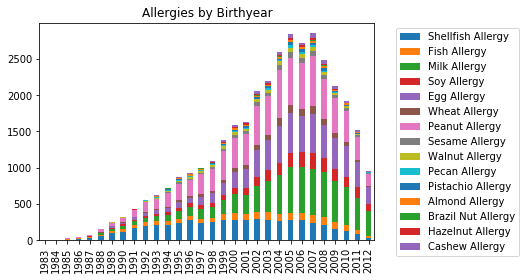

In [10]:
# Create stacked bar graph showcasing most common allergies by birth year
birth_allergy.index = birth_years
birth_allergy
birth_allergy.plot(kind='bar',stacked=True, title = "Allergies by Birthyear")
plt.legend(bbox_to_anchor = (1.05,1.0), loc = 'upper left')

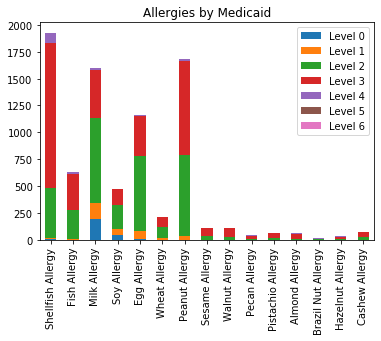

In [11]:
# Create DataFrames for medicaid and non-medicaid severity levels by allergy 
medicaid_rates = pd.DataFrame()
nonmedicaid_rates = pd.DataFrame()
# Masks to help differentiate rows
medicaid_mask = food_allergy_clean[food_allergy_clean["PAYER_FACTOR"]=="P1 - Medicaid"]
nonmedicaid_mask = food_allergy_clean[food_allergy_clean["PAYER_FACTOR"]=="P0 - Non-Medicaid"]

medicaid_allergy_name = []

# Save new DataFrame containing severity levels by allergy with masks applied
for keys, values in allergyDict.items():
    medicaid_allergy_name.append(keys)
    df = pd.DataFrame(medicaid_mask.groupby(allergyDict[keys][0]).size())
    df1 = df.T
    medicaid_rates = pd.concat([medicaid_rates, df1])
    
nonmedicaid_allergy_name = []   
for keys, values in allergyDict.items():
    nonmedicaid_allergy_name.append(keys)
    df = pd.DataFrame(nonmedicaid_mask.groupby(allergyDict[keys][0]).size())
    df1 = df.T
    nonmedicaid_rates = pd.concat([nonmedicaid_rates, df1])
# Set indexes to allergy name    
medicaid_rates.index=medicaid_allergy_name
nonmedicaid_rates.index=nonmedicaid_allergy_name
medicaid_rates

# Plot
medicaid_rates.plot(kind='bar',stacked=True, title = "Allergies by Medicaid")
plt.legend(labels = labels)

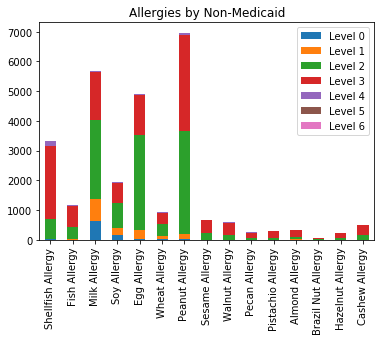

In [12]:
nonmedicaid_rates
nonmedicaid_rates.plot(kind='bar',stacked=True, title = "Allergies by Non-Medicaid")
plt.legend(labels = labels)

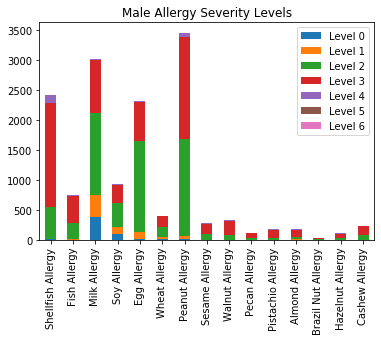

In [19]:
# Create DataFrames for male and female severity levels by allergy 
male_rates = pd.DataFrame()
female_rates = pd.DataFrame()

# Masks to help differentiate rows
male_mask = food_allergy_clean[food_allergy_clean["GENDER_FACTOR"]=="S1 - Female"]
female_mask = food_allergy_clean[food_allergy_clean["GENDER_FACTOR"]=="S0 - Male"]

# Save new DataFrame containing severity levels by allergy with masks applied
male_allergy_name = []
male_count = []

for keys, values in allergyDict.items():
    male_allergy_name.append(keys)
    df = pd.DataFrame(male_mask.groupby(allergyDict[keys][0]).size())
    df1 = df.T
    male_rates = pd.concat([male_rates, df1])

female_allergy_name = [] 
female_count = []

for keys, values in allergyDict.items():
    female_allergy_name.append(keys)
    df = pd.DataFrame(female_mask.groupby(allergyDict[keys][0]).size())
    df1 = df.T
    female_rates = pd.concat([female_rates, df1])
    
# Set indexes to allergy name        
female_rates.index=female_allergy_name
male_rates.index=male_allergy_name
male_rates
# Plot
male_rates.plot(kind='bar',stacked=True, title = "Male Allergy Severity Levels")
plt.legend(labels = labels)

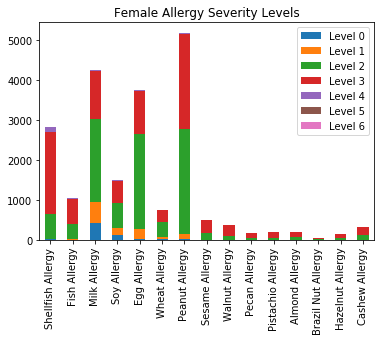

In [20]:
female_rates
female_rates.plot(kind='bar',stacked=True, title = "Female Allergy Severity Levels")
plt.legend(labels = labels)